In [1]:
!nvidia-smi

Mon Apr  4 13:36:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:8B:00.0 Off |                  N/A |
| 34%   29C    P0    26W / 105W |      0MiB /  8117MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Inštalácia knižníc

In [2]:
!pip install opencv-python
!pip install keras
!pip install scikit-plot

### Import knižníc

In [1]:
from sys import stdout
from tensorflow import keras
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from csv import DictWriter

import tensorflow as tf
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle as pkl

### Zadefinovanie funkcie

In [ ]:
#vykreslenie procesu učenia
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training accuracy')
    plt.plot(x, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Načítanie snímok

In [6]:
with open('train.pkl','rb') as f: X_train, train_df = pkl.load(f)
with open('test.pkl','rb') as f: X_test, test_df = pkl.load(f)
with open('valid.pkl','rb') as f: X_valid, valid_df = pkl.load(f)

y_train = train_df["category"]
y_test = test_df["category"]
y_valid = valid_df["category"]

In [7]:
print("TrainSetInto = {}".format(X_train.shape))
print("TestSetInto = {}".format(X_test.shape))
print("ValidSetInto = {}".format(X_valid.shape))

TrainSetInto = (4668, 299, 299, 1)
TestSetInto = (1191, 299, 299, 1)
ValidSetInto = (100, 299, 299, 1)


<AxesSubplot:>

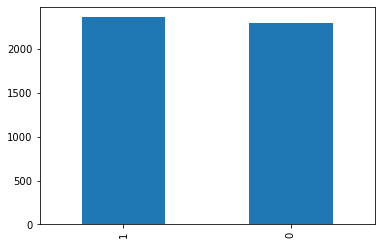

In [8]:
y_train.value_counts().plot.bar()

<AxesSubplot:>

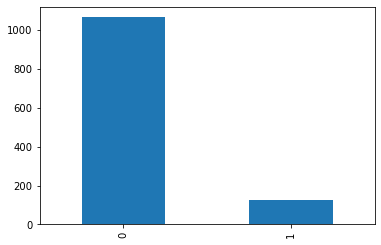

In [9]:
y_test.value_counts().plot.bar()

<AxesSubplot:>

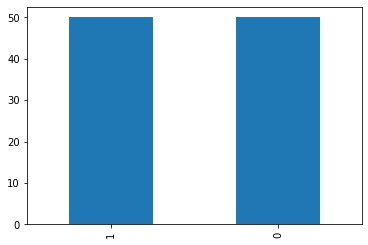

In [10]:
y_valid.value_counts().plot.bar()

### Architektúra siete

In [11]:
epochs = 40
batch_size = 32


model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=[299, 299,1], activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 295, 295, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 295, 295, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 147, 147, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 147, 147, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 145, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 143, 143, 32)      9

### Vytvorenie záchytných bodov

In [12]:
STEPS_PER_EPOCH = y_train.size / batch_size
SAVE_PERIOD = 2

filepath = "../FrantisekUrban/wandb_models_weights/honest-sweep-24-{epoch:02d}.h5"
checkpoint1 = ModelCheckpoint(filepath, verbose=1, save_best_only=False, save_weights_only=True, save_freq=int(SAVE_PERIOD * STEPS_PER_EPOCH))

### Augmentácia datasetu (trénovacia množina)

In [13]:
train_datagen = ImageDataGenerator(vertical_flip=True,horizontal_flip=True, brightness_range=[0.3,0.7])
train_img_gen = train_datagen.flow(X_train, y_train,
                                       batch_size=batch_size)

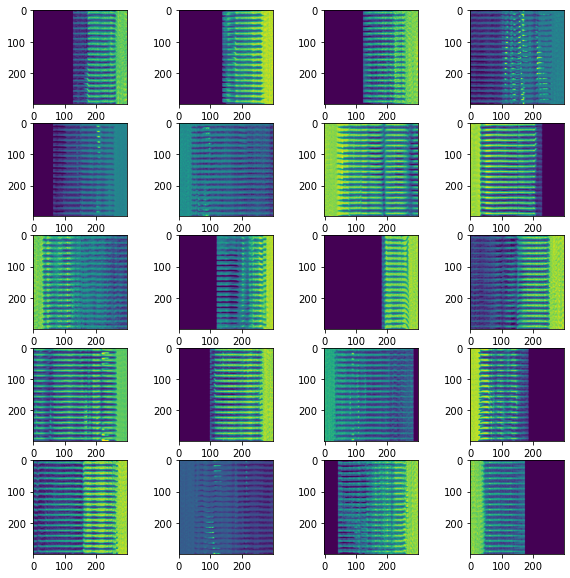

In [14]:
# vykreslenie výstupu augmentácie  
x_batch, y_batch = next(train_img_gen)
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
for i in range (1, columns*rows +1):
    image = x_batch[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

### Trénovanie modelu

In [18]:
history = model.fit(train_img_gen,
                    validation_data = (X_valid, y_valid),
                    callbacks = [checkpoint1],
                    epochs=epochs)

Epoch 1/40
146/146 [==============================] - 34s 231ms/step - loss: 4.7681 - accuracy: 0.6545 - val_loss: 1.3235 - val_accuracy: 0.6000
Epoch 2/40
144/146 [============================>.] - ETA: 0s - loss: 1.1835 - accuracy: 0.6970
Epoch 00002: saving model to ../FrantisekUrban/wandb_models_weights/honest-sweep-24-02.h5
146/146 [==============================] - 33s 227ms/step - loss: 1.1738 - accuracy: 0.6975 - val_loss: 6.8208 - val_accuracy: 0.4400
Epoch 3/40
146/146 [==============================] - 32s 220ms/step - loss: 0.5977 - accuracy: 0.7434 - val_loss: 1.0702 - val_accuracy: 0.6300
Epoch 4/40
143/146 [============================>.] - ETA: 0s - loss: 0.4915 - accuracy: 0.7662
Epoch 00004: saving model to ../FrantisekUrban/wandb_models_weights/honest-sweep-24-04.h5
146/146 [==============================] - 33s 228ms/step - loss: 0.4902 - accuracy: 0.7648 - val_loss: 0.7869 - val_accuracy: 0.5700
Epoch 5/40
146/146 [==============================] - 32s 221ms/step -

### Vyhodnotenie výsledkov procesu trénovania

In [8]:
# zadefinovanie architektúry modelu
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=[299, 299,1], activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [9]:
#načítanie výtvorených váh
weights = glob.glob("../FrantisekUrban/wandb_models_weights/" + "*.h5")
weights[100:120]

['../FrantisekUrban/wandb_models_weights/honest-sweep-24-02.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-04.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-06.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-08.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-10.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-12.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-14.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-16.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-18.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-20.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-22.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-24.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-26.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-28.h5',
 '../FrantisekUrban/wandb_models_weights/honest-sweep-24-30.h5',
 '../FrantisekUrban/wandb

In [15]:
# vytvorenie dataframu pre uloženie výsledkov
header = ["Model", "Accuracy", "Loss", "AUC"]
dataframe = pd.DataFrame(columns = header)  
dataframe

,Model,Accuracy,Loss,AUC


In [16]:
# vyhodnotenie modelov
for weight in weights[100:120]:
    new_model = create_model()
    new_model.load_weights(weight)
    print(weight.split("/")[3])
    score = new_model.evaluate(X_test, y_test)
    
    y_pred = new_model.predict(X_test)
    y_int = np.zeros_like(y_pred)
    y_int[y_pred > 0.50] = 1
    y_testt = y_test.astype('float32')
    print("DONE")
    
    cm = confusion_matrix(y_testt, y_int)
    print('Confusion_matrix')
    print(cm)
    print('-------------------Classification_report-------------------')
    target_names = ['Negative', 'Positive']
    print(classification_report(y_testt, y_int, target_names=target_names))
    
    rocauc = roc_auc_score(y_test, y_pred)
    print('AUC: {}'.format(rocauc))
    print(" ")
    
    row = {'Model': weight.split("/")[3],
           'Accuracy': round(score[1],4),
           'Loss': round(score[0],4),
           'AUC':round(rocauc,4) ,
          }
    dataframe = dataframe.append(row, ignore_index=True)

honest-sweep-24-02.h5
38/38 [==============================] - 3s 72ms/step - loss: 7.9783 - accuracy: 0.3887
DONE
Confusion_matrix
[[376 690]
 [ 38  87]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.91      0.35      0.51      1066
    Positive       0.11      0.70      0.19       125

    accuracy                           0.39      1191
   macro avg       0.51      0.52      0.35      1191
weighted avg       0.82      0.39      0.48      1191

AUC: 0.46170731707317075
 
honest-sweep-24-04.h5
38/38 [==============================] - 3s 66ms/step - loss: 0.3584 - accuracy: 0.8472
DONE
Confusion_matrix
[[965 101]
 [ 81  44]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.92      0.91      0.91      1066
    Positive       0.30      0.35      0.33       125

    accuracy                           0.85      119

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


honest-sweep-24-26.h5
38/38 [==============================] - 3s 68ms/step - loss: 0.3073 - accuracy: 0.8900
DONE
Confusion_matrix
[[975  91]
 [ 40  85]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.96      0.91      0.94      1066
    Positive       0.48      0.68      0.56       125

    accuracy                           0.89      1191
   macro avg       0.72      0.80      0.75      1191
weighted avg       0.91      0.89      0.90      1191

AUC: 0.9103714821763602
 
honest-sweep-24-28.h5
38/38 [==============================] - 3s 67ms/step - loss: 1.8751 - accuracy: 0.8950
DONE
Confusion_matrix
[[1066    0]
 [ 125    0]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.90      1.00      0.94      1066
    Positive       0.00      0.00      0.00       125

    accuracy                           0.90      

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


honest-sweep-24-30.h5
38/38 [==============================] - 3s 67ms/step - loss: 0.2988 - accuracy: 0.8707
DONE
Confusion_matrix
[[934 132]
 [ 22 103]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.98      0.88      0.92      1066
    Positive       0.44      0.82      0.57       125

    accuracy                           0.87      1191
   macro avg       0.71      0.85      0.75      1191
weighted avg       0.92      0.87      0.89      1191

AUC: 0.9318574108818012
 
honest-sweep-24-32.h5
38/38 [==============================] - 3s 69ms/step - loss: 2.9872 - accuracy: 0.3191
DONE
Confusion_matrix
[[256 810]
 [  1 124]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       1.00      0.24      0.39      1066
    Positive       0.13      0.99      0.23       125

    accuracy                           0.32      1191

In [17]:
#zobrazenie dosiahnutých výsledkov
dataframe

,Model,Accuracy,Loss,AUC
0,honest-sweep-24-02.h5,0.3887,7.9783,0.4617
1,honest-sweep-24-04.h5,0.8472,0.3584,0.7688
2,honest-sweep-24-06.h5,0.9001,0.2981,0.7874
3,honest-sweep-24-08.h5,0.6499,0.8314,0.8481
4,honest-sweep-24-10.h5,0.8950,0.3005,0.8442
5,honest-sweep-24-12.h5,0.8757,0.2663,0.9282
6,honest-sweep-24-14.h5,0.4374,1.4568,0.9028
7,honest-sweep-24-16.h5,0.8589,0.3053,0.8521
8,honest-sweep-24-18.h5,0.9437,0.1978,0.9083
9,honest-sweep-24-20.h5,0.9463,0.2214,0.9172


In [ ]:
#uloženie dataframu
dataframe.to_csv("../FrantisekUrban/wandb_models_weights/honest-sweep-24.csv", index=False)

In [11]:
weights[116]

'../FrantisekUrban/wandb_models_weights/honest-sweep-24-34.h5'

### Vyhodnotenie najlepšieho modelu

In [12]:
# vyhodnotenie na prahu = 0.5
new_model = create_model()
new_model.load_weights(weights[116])
print(weights[116].split("/")[3])
new_model.evaluate(X_test, y_test)

y_pred = new_model.predict(X_test)

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
y_testt = y_test.astype('float32')
print("DONE")

cm = confusion_matrix(y_testt, y_int)
print('Confusion_matrix')
print(cm)
print('-------------------Classification_report-------------------')
target_names = ['Negative', 'Positive']
print(classification_report(y_testt, y_int, target_names=target_names))

rocauc = roc_auc_score(y_test, y_pred)
print('AUC: {}'.format(round(rocauc, 4)))

honest-sweep-24-34.h5
38/38 [==============================] - 3s 73ms/step - loss: 0.2686 - accuracy: 0.9312
DONE
Confusion_matrix
[[1015   51]
 [  31   94]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.97      0.95      0.96      1066
    Positive       0.65      0.75      0.70       125

    accuracy                           0.93      1191
   macro avg       0.81      0.85      0.83      1191
weighted avg       0.94      0.93      0.93      1191

AUC: 0.9396


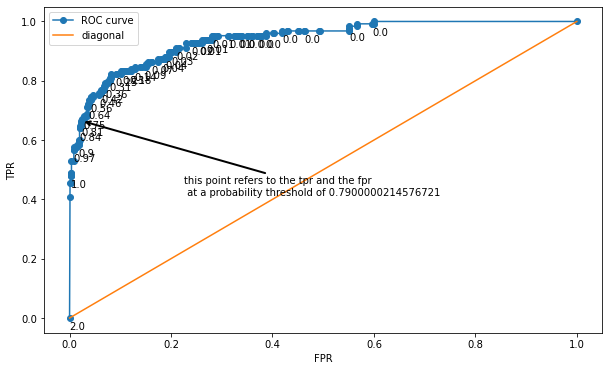

In [13]:
# vykreslenie ROC krivky s optimálnou hodnotou prahu
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, 'o-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::5], tpr[::5], thresholds[::5]):
    plt.annotate(np.round(txt,2), (x, y-0.04))
rnd_idx = 27
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'.format(np.round(thresholds[rnd_idx], 2)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("../FrantisekUrban/plots/honest-ROCcurve.png", bbox_inches='tight', dpi = 200)

In [14]:
# vyhodnotenie pri optimálnej hodnote prahu = 0.79
new_model = create_model()
new_model.load_weights(weights[116])
print(weights[116].split("/")[3])
new_model.evaluate(X_test, y_test)

y_pred = new_model.predict(X_test)

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.79] = 1
y_testt = y_test.astype('float32')
print("DONE")

cm = confusion_matrix(y_testt, y_int)
print('Confusion_matrix')
print(cm)
print('-------------------Classification_report-------------------')
target_names = ['Negative', 'Positive']
print(classification_report(y_testt, y_int, target_names=target_names))

rocauc = roc_auc_score(y_test, y_pred)
print('AUC: {}'.format(round(rocauc, 4)))

honest-sweep-24-34.h5
38/38 [==============================] - 3s 69ms/step - loss: 0.2686 - accuracy: 0.9312
DONE
Confusion_matrix
[[1039   27]
 [  42   83]]
-------------------Classification_report-------------------
              precision    recall  f1-score   support

    Negative       0.96      0.97      0.97      1066
    Positive       0.75      0.66      0.71       125

    accuracy                           0.94      1191
   macro avg       0.86      0.82      0.84      1191
weighted avg       0.94      0.94      0.94      1191

AUC: 0.9396


In [2]:
#načítanie uloženého dataframu vysledkov
dataframe = pd.read_csv('../FrantisekUrban/wandb_models_weights/honest-sweep-24.csv')
dataframe

,Model,Accuracy,Loss,AUC
0,honest-sweep-24-02.h5,0.3887,7.9783,0.4617
1,honest-sweep-24-04.h5,0.8472,0.3584,0.7688
2,honest-sweep-24-06.h5,0.9001,0.2981,0.7874
3,honest-sweep-24-08.h5,0.6499,0.8314,0.8481
4,honest-sweep-24-10.h5,0.8950,0.3005,0.8442
5,honest-sweep-24-12.h5,0.8757,0.2663,0.9282
6,honest-sweep-24-14.h5,0.4374,1.4568,0.9028
7,honest-sweep-24-16.h5,0.8589,0.3053,0.8521
8,honest-sweep-24-18.h5,0.9437,0.1978,0.9083
9,honest-sweep-24-20.h5,0.9463,0.2214,0.9172


### Grafická reprezentácia výsledkov

In [3]:
# načítanie AUC a Úspešnosti
acc = dataframe["Accuracy"]
auc = dataframe["AUC"]

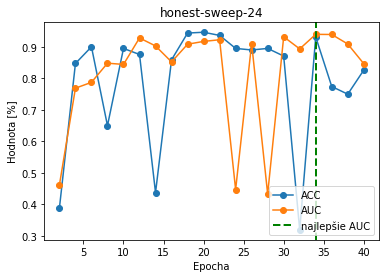

In [4]:
# vykreslenie grafu
epochs = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]

plt.plot(epochs, acc, label = 'ACC', linestyle='-', marker='o')
plt.plot(epochs, auc, label = 'AUC', linestyle='-', marker='o')

plt.axvline(x = 34, ls='--', lw=2, c='green', label='najlepšie AUC')
# naming the x axis
plt.xlabel('Epocha')
# naming the y axis
plt.ylabel('Hodnota [%]')
plt.title('honest-sweep-24')
plt.legend(loc ="lower right")
plt.savefig("../FrantisekUrban/plots/honestplot-vysledok-epoch.png", bbox_inches='tight', dpi = 200)
plt.show()